# Latent Space Variational Geologic  Inversion from Multi-Source Dynamic Data
### Misael M. Morales, 2023
***

In [1]:
# Load my project packages
from utils_2d import *

# restart keras
import keras
keras.backend.clear_session()

In [2]:
# Check tensorflow GPU settings
check_tensorflow_gpu()

Tensorflow built with CUDA? True
Tensorflow version: 2.10.0
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
# Load all data and Visualize

In [3]:
### Load individual datasets from simulations
timestamps, poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut = load_initial_data()

Perm: (1000, 128, 128) | Poro: (1000, 128, 128) | Channels: (1000, 128, 128) | Pressure: (1000, 45, 128, 128) | Saturation: (1000, 45, 128, 128)
OPR: (1000, 45, 3) | WPR: (1000, 45, 3) | WCUT: (1000, 45, 3) | Timestamps: (45,)


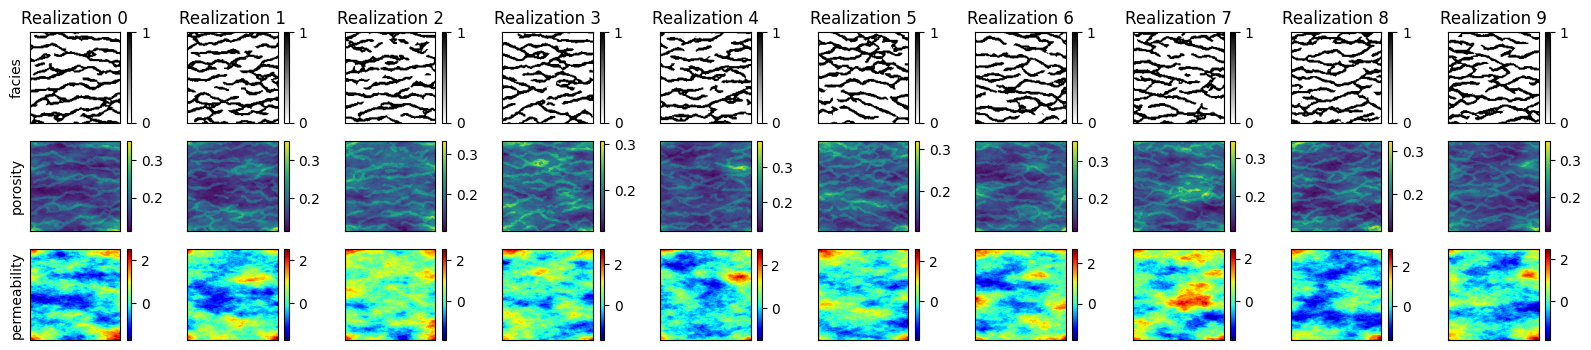

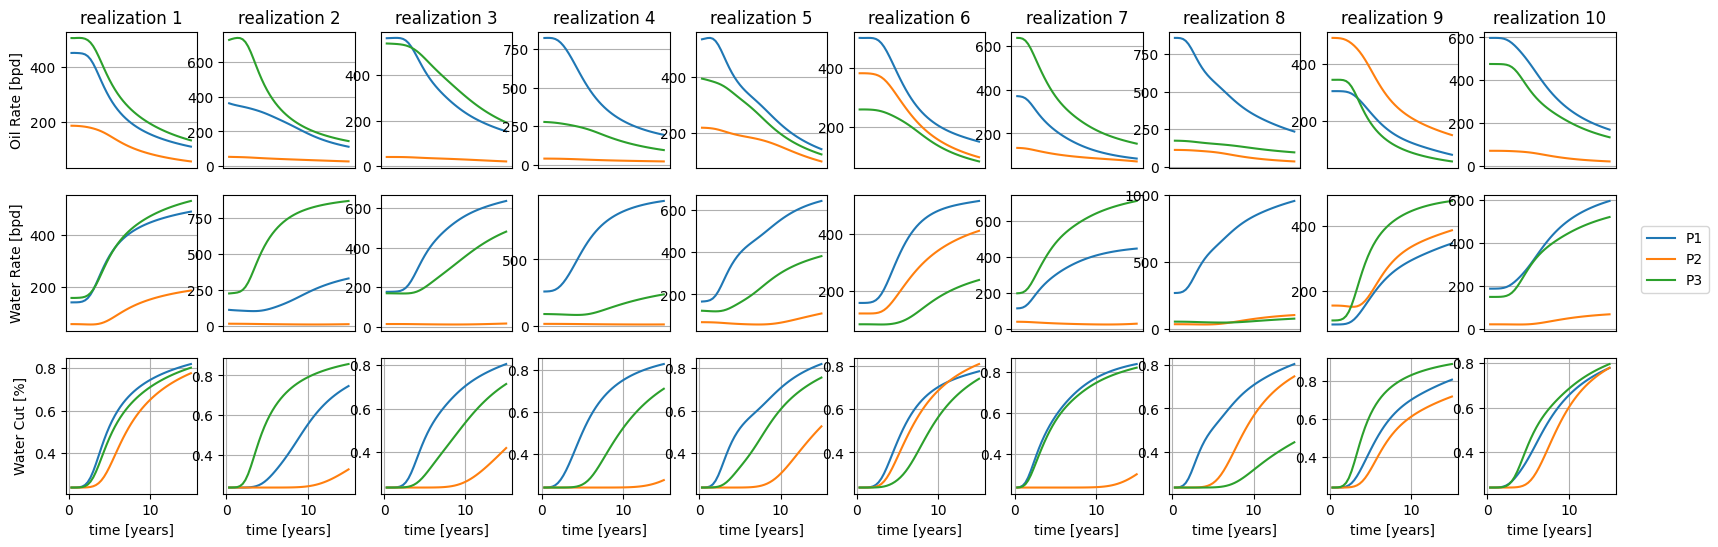

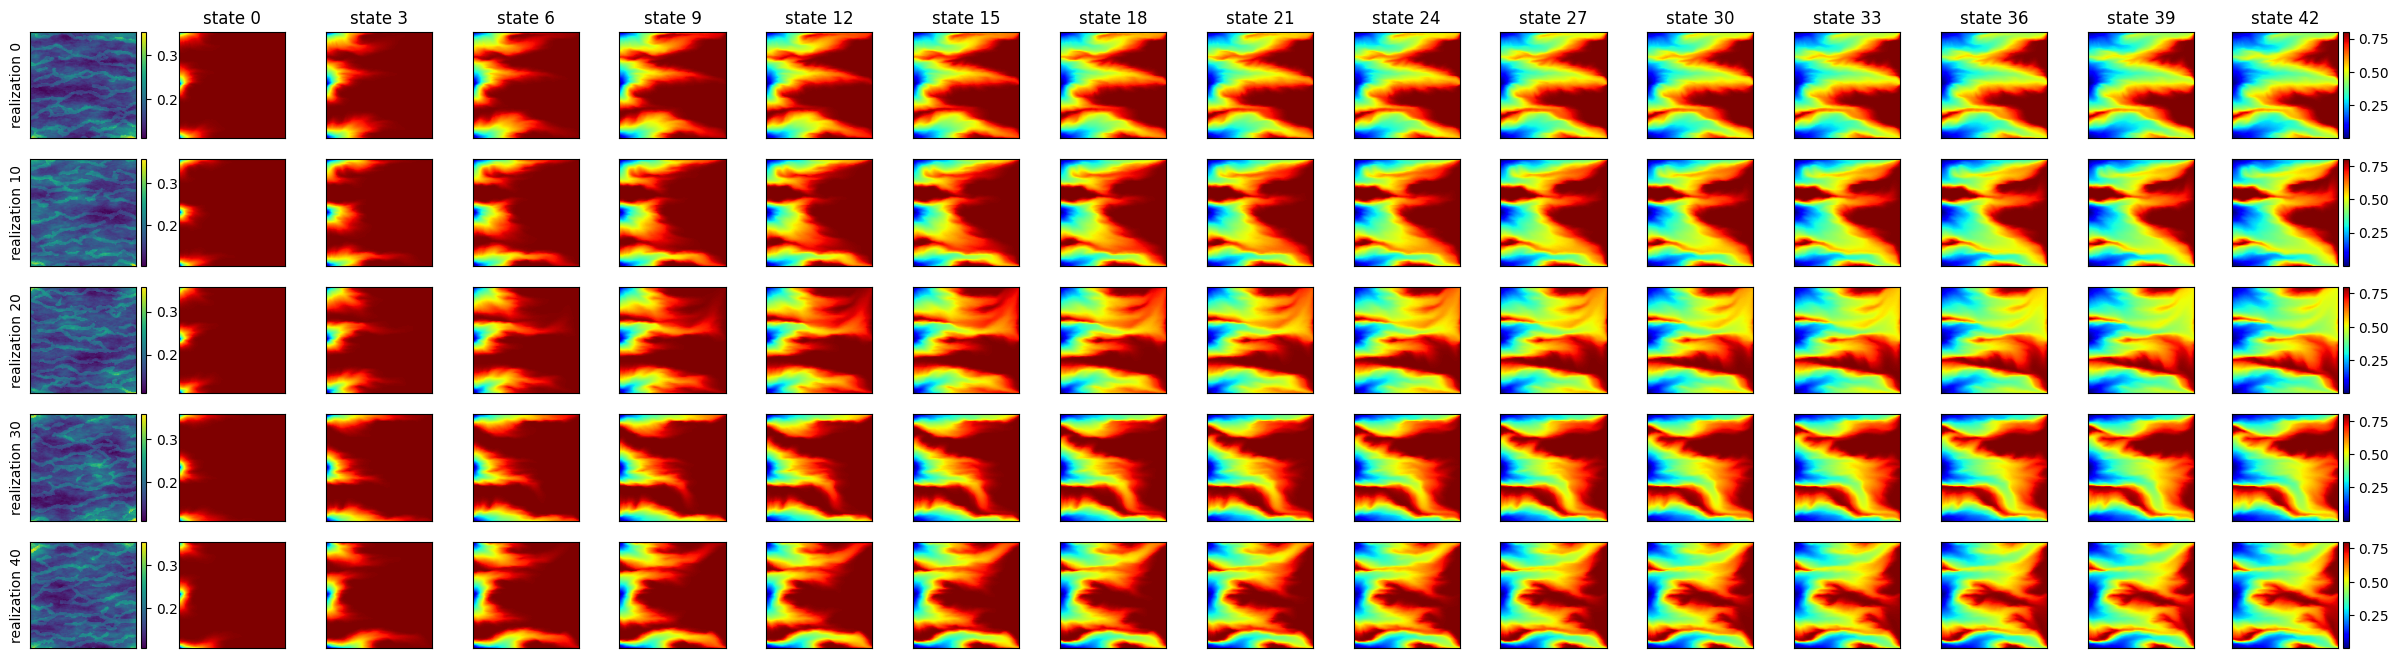

In [4]:
plot_static(poro, perm, channels)
plot_data(timestamps, well_opr, well_wpr, well_wcut)
plot_dynamic(poro, saturation, multiplier=10, cmaps=['viridis','jet'])

MovieWriter ffmpeg unavailable; using Pillow instead.


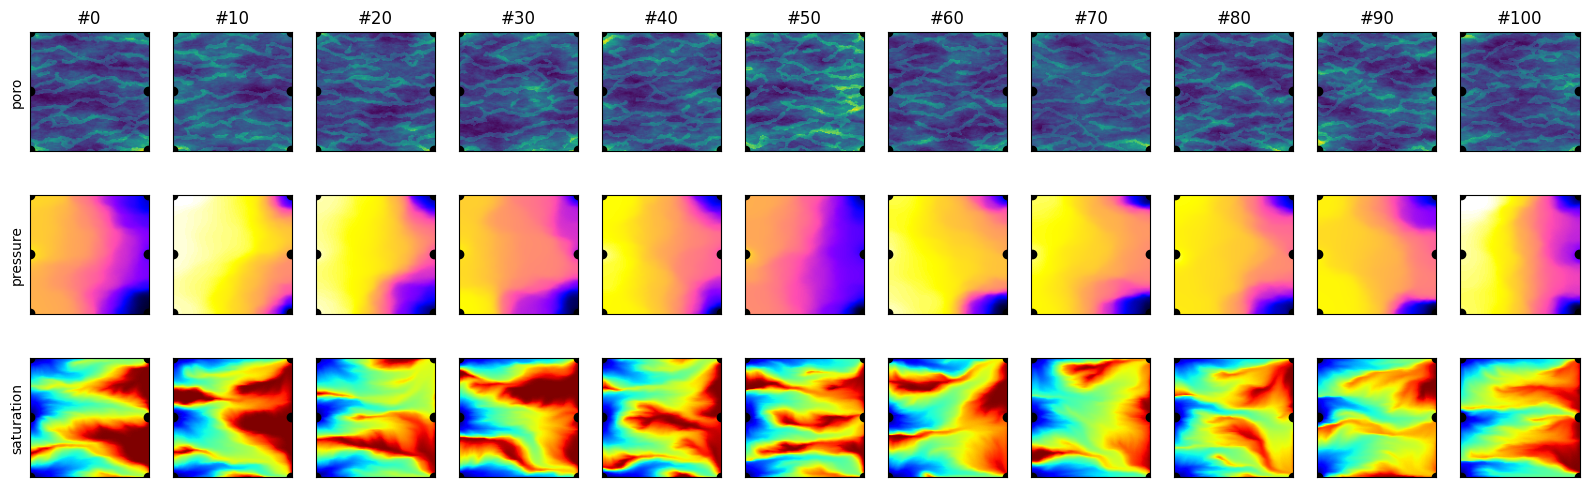

In [5]:
make_dynamic_animation(poro, [pressure,saturation])

***
# Data Processing
Load pre-existing data

Normalization, concatenate features and targets, train-test split

In [7]:
### (a) To split and normalize data into (x,y,w):
# X_data, y_data, w_data = split_xyw(poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut)

### (b) To load pre-computed, normalized (X,y,w,t):
X_data, y_data, w_data, timestamps = load_xywt()

X shape: (1000, 45, 128, 128, 2) | y shape: (1000, 45, 3, 3) 
w shape: (1000, 128, 128, 3) | t shape: (45,)


In [8]:
# Perform train-test split
X_train, X_test, y_train, y_test, w_train, w_test, randx, randy = my_train_test_split(X_data, y_data, w_data, nobs=30)

X_train shape: (700, 45, 30, 2)   | X_test shape: (300, 45, 30, 2)
w_train shape: (700, 45, 3, 3)    | w_test shape: (300, 45, 3, 3)
y_train shape: (700, 128, 128, 3) | y_test shape: (300, 128, 128, 3)


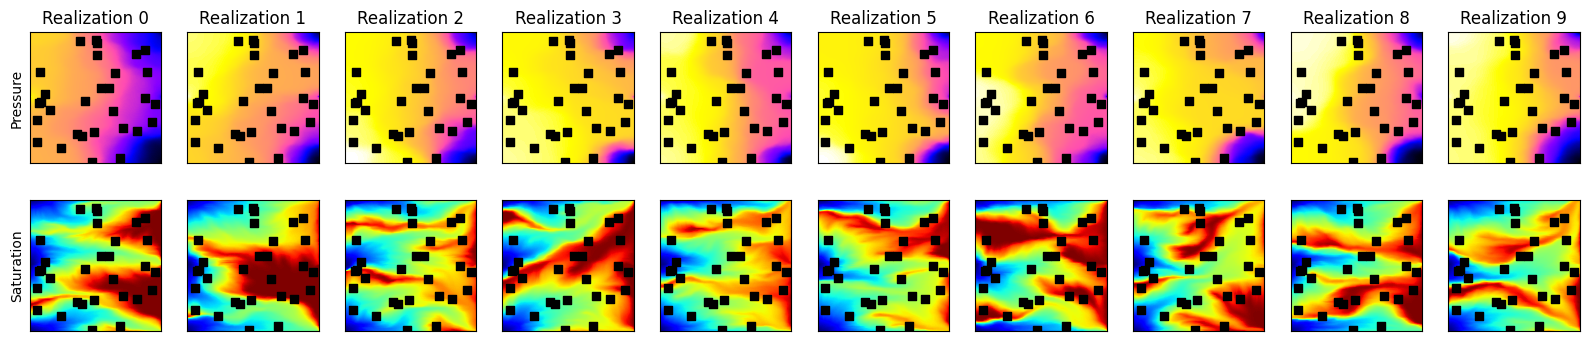

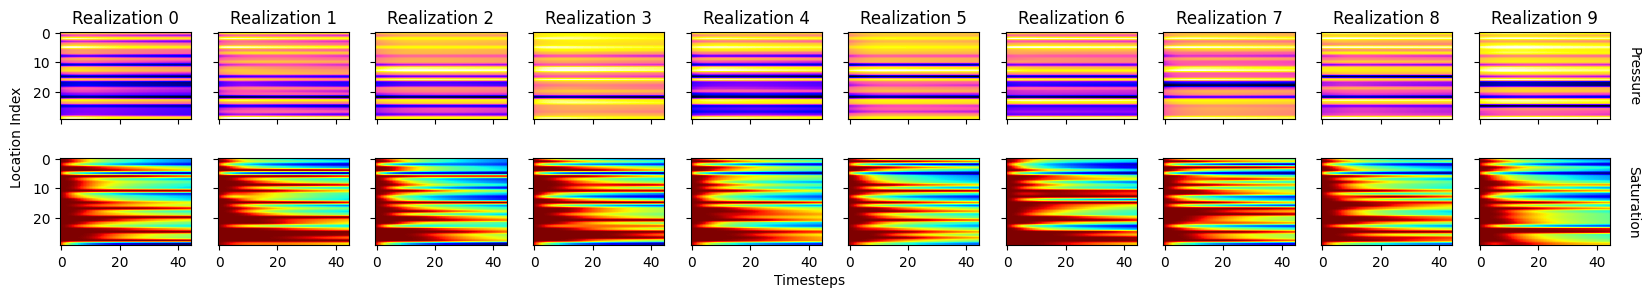

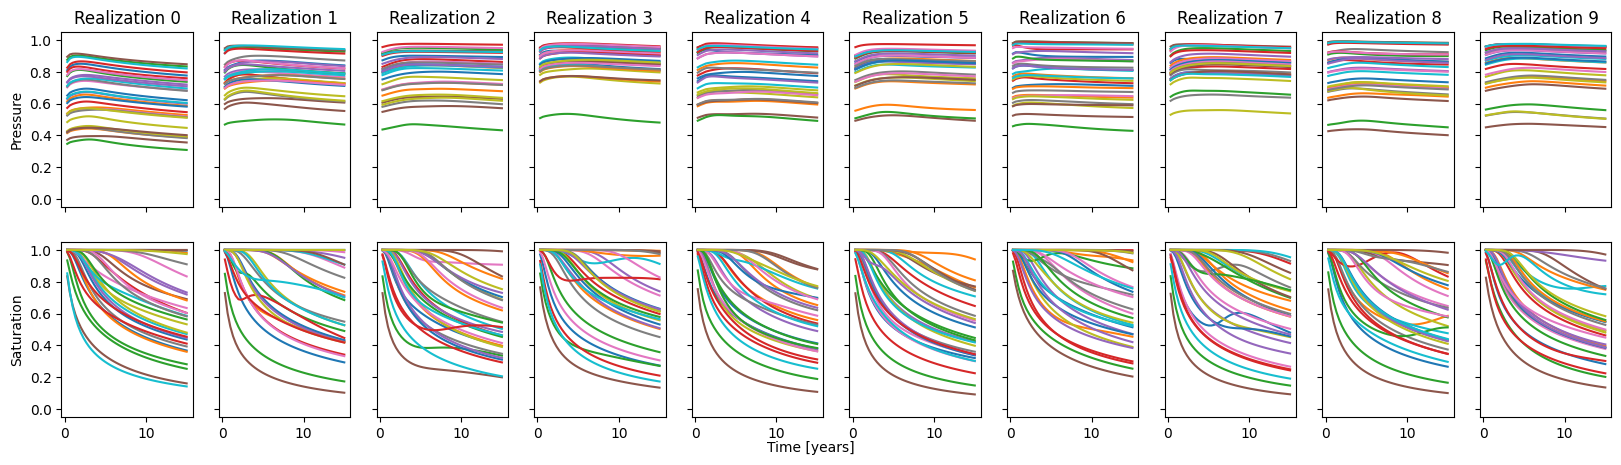

In [9]:
# Visualize X-samples
plot_X_img_observation(X_data, randx, randy)
plot_X_observation(X_train)
plot_X_line_observation(X_train, timestamps)

***
# Build, Compile, Train, and Predict with AutoEncoder Models
Run Train/Test Predictions

# Parameters: 308,025 | Training time: 0.23 minutes
# Parameters: 40,238 | Training time: 4.33 minutes
# Parameters: 5,610,120 | Training time: 0.28 minutes


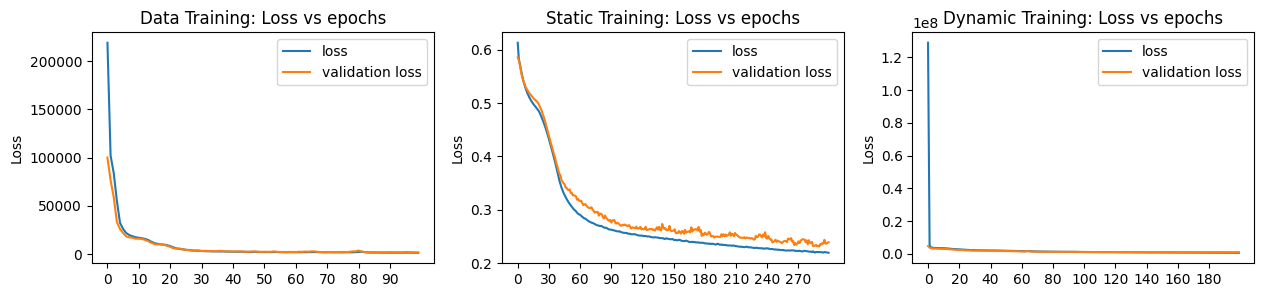

In [9]:
data_enc,    data_dec,    data_ae,    data_fit    = make_data_ae(w_train)
static_enc,  static_dec,  static_ae,  static_fit  = make_static_ae(y_train)
dynamic_enc, dynamic_dec, dynamic_ae, dynamic_fit = make_dynamic_ae(X_train)
plot_loss_all(data_fit, static_fit, dynamic_fit)

10/10 [==============================] - 0s 3ms/step
Train MSE: 5.55e-04 | Test MSE: 5.55e-04
Image data must have shape at least (7x7) for ssim calculation


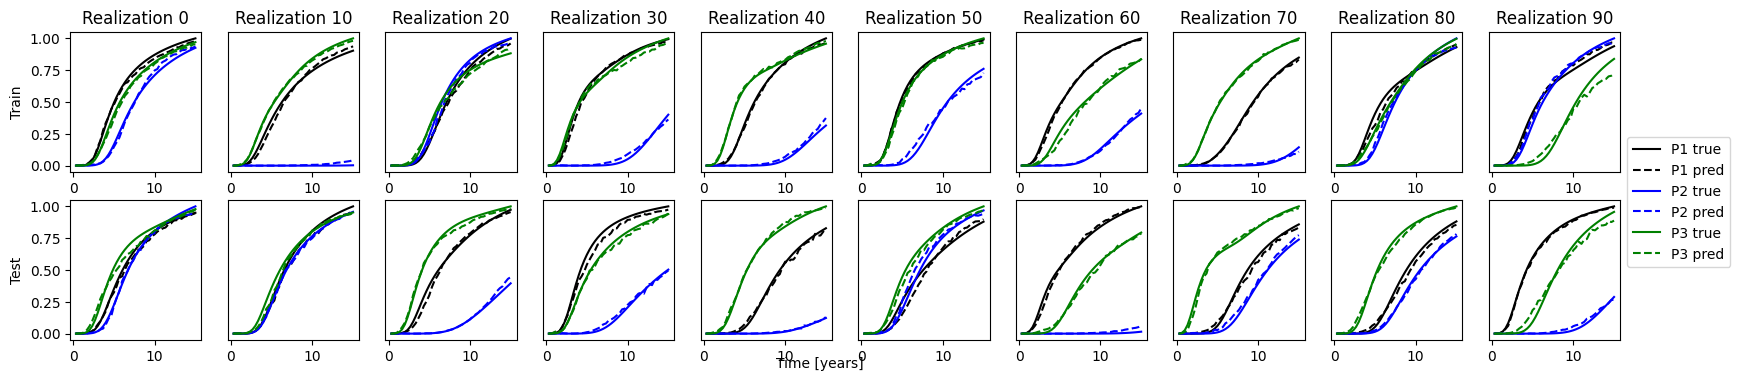

In [10]:
w_train_pred, w_test_pred = make_ae_prediction(w_train, w_test, data_ae)
plot_data_results(timestamps, w_train, w_test, w_train_pred, w_test_pred, channel_select=2, multiplier=10)

10/10 [==============================] - 0s 12ms/step
Train MSE: 2.90e-02 | Test MSE: 2.90e-02
Train SSIM: 84.36 | Test SSIM: 84.01


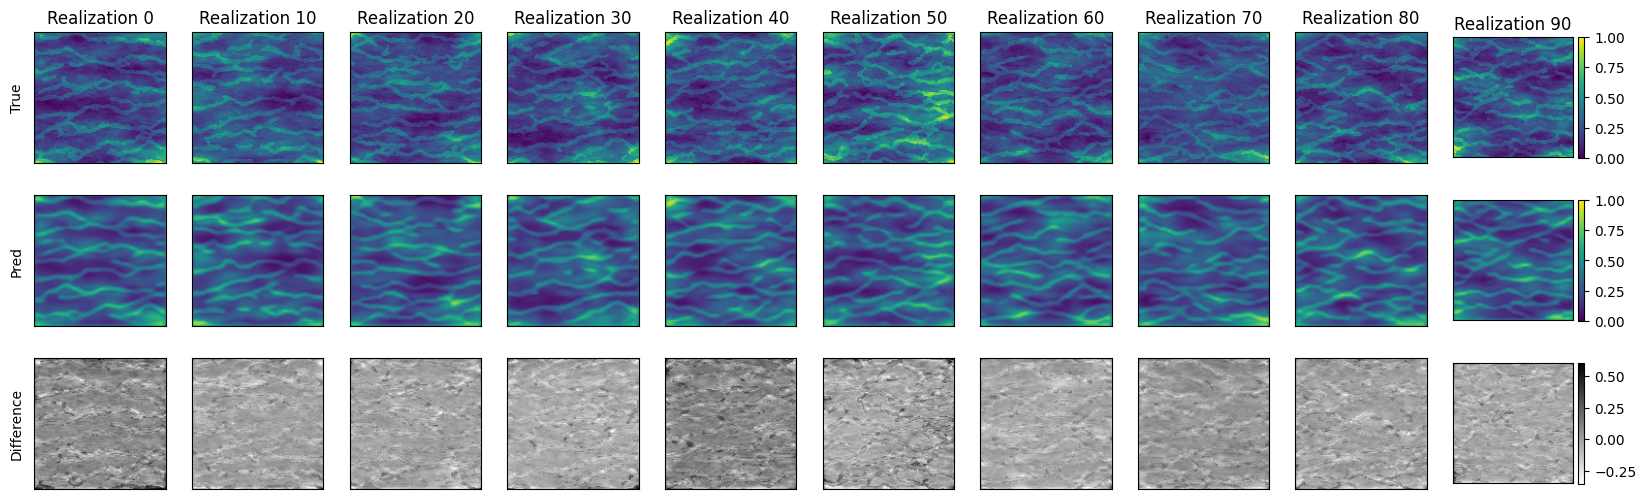

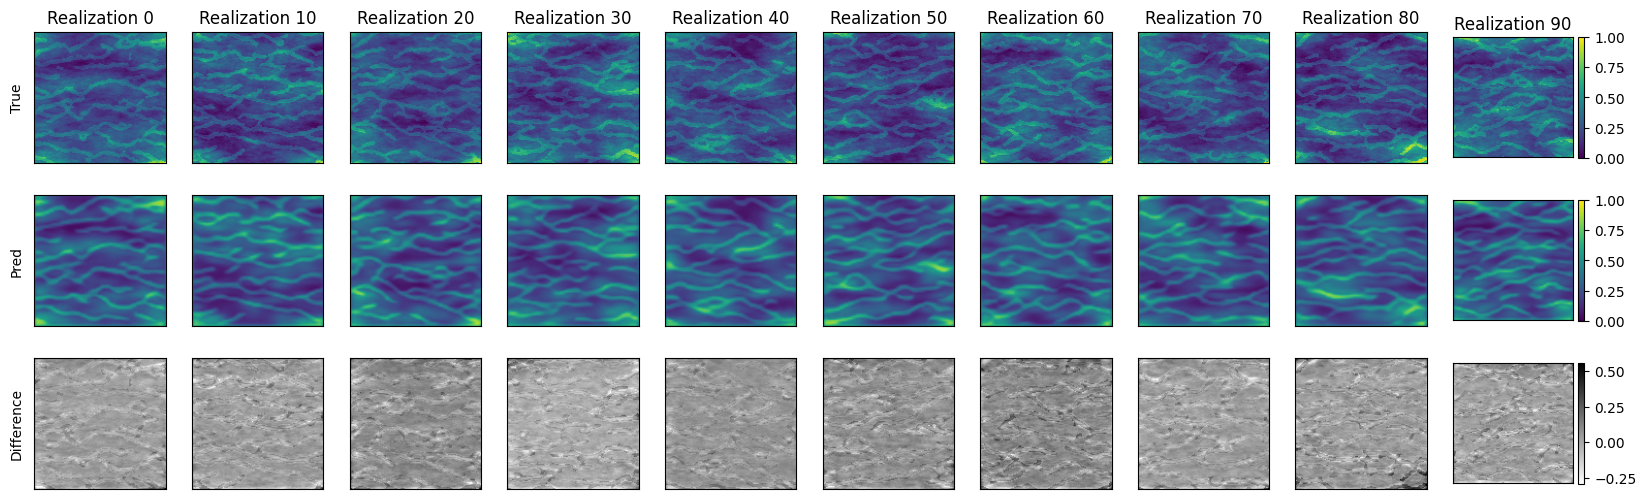

In [11]:
y_train_pred, y_test_pred = make_ae_prediction(y_train, y_test, static_ae)
plot_static_results(y_train, y_train_pred, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])
plot_static_results(y_test, y_test_pred, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

10/10 [==============================] - 0s 2ms/step
Train MSE: 2.53e-03 | Test MSE: 2.53e-03
Train SSIM: 96.04 | Test SSIM: 94.07


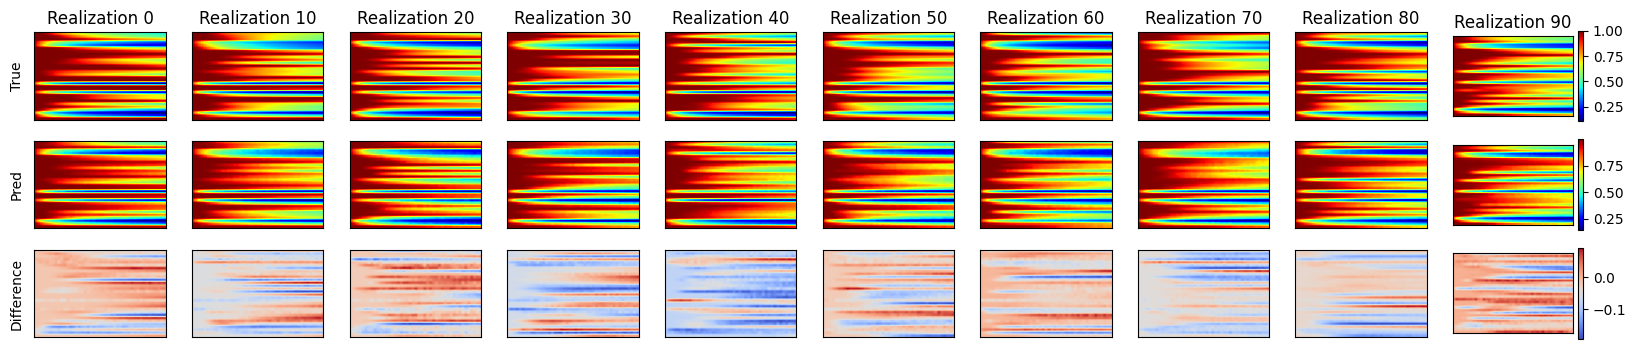

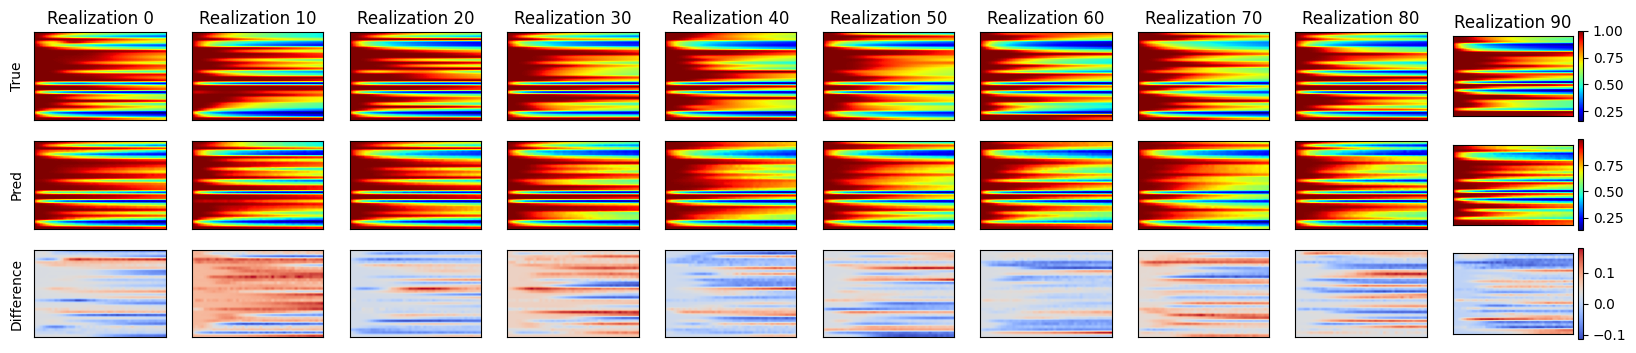

In [12]:
X_train_pred, X_test_pred = make_ae_prediction(X_train, X_test, dynamic_ae)
plot_dynamic_results(X_train, X_train_pred, multiplier=10, channel_select=1)
plot_dynamic_results(X_test, X_test_pred, multiplier=10, channel_select=1)

***
# Build, Compile, Train, and Predict with Latent-Inversion Network

In [13]:
X_full, w_full, y_full = make_full_traintest(X_train, X_test, w_train, w_test, y_train, y_test)

X_full: (1000, 45, 30, 2) | w_full: (1000, 45, 3, 3) | y_full: (1000, 128, 128, 3)


# Parameters: 62,959,895 | Training time: 3.41 minutes


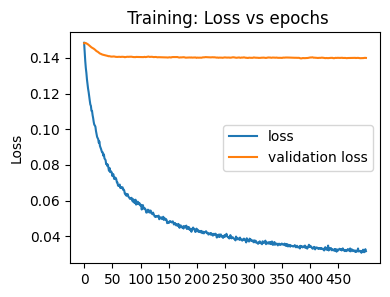

In [14]:
reg, reg_fit = make_inv_regressor(X_full, w_full, y_full, dynamic_enc, data_enc, static_dec)
plot_loss(reg_fit, figsize=(4,3))

In [15]:
inv_train, inv_test = make_inv_prediction(reg, [X_train, X_test], [w_train, w_test], y_train, y_test)

10/10 [==============================] - 0s 11ms/step
Train MSE: 2.62e-02 | Test MSE: 1.02e-01
Train SSIM: 81.46 | Test SSIM: 41.19


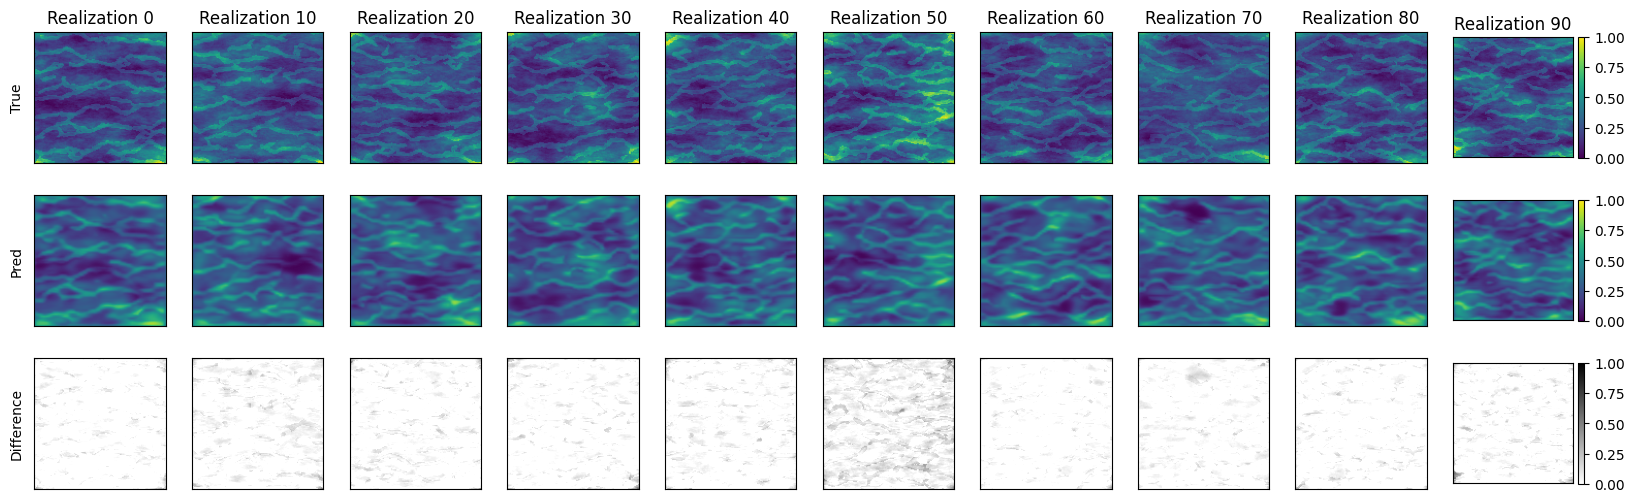

In [16]:
plot_inversion_result(y_train, inv_train, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

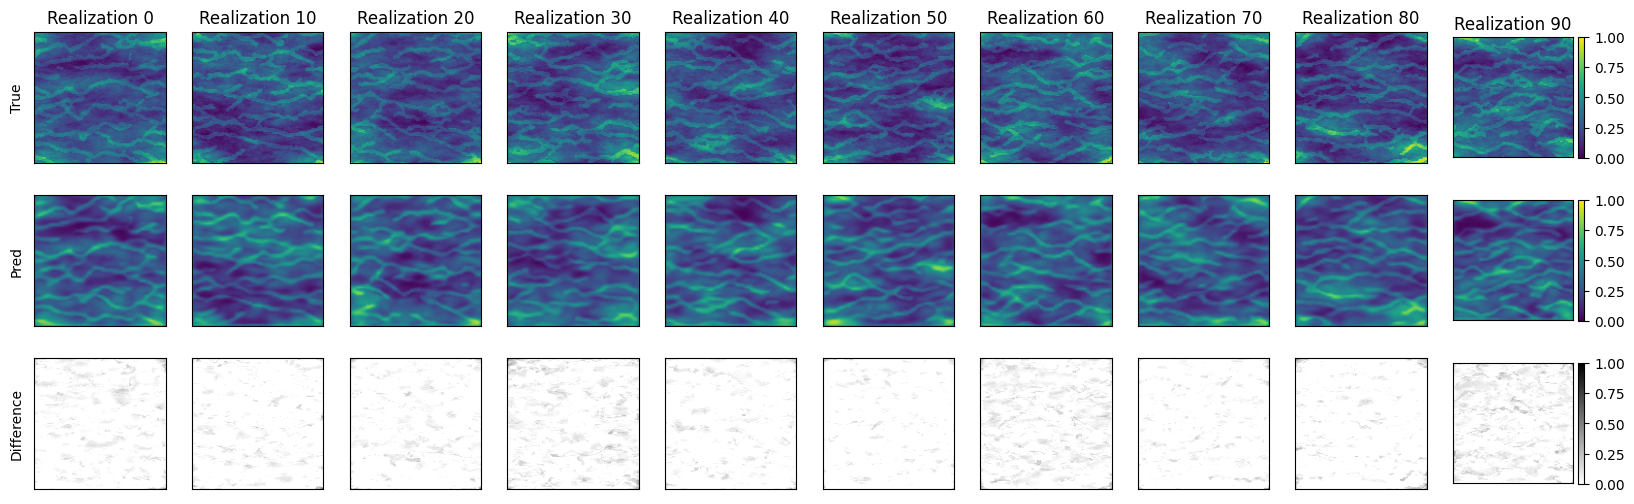

In [17]:
plot_inversion_result(y_test, inv_test, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

***
# Back-Normalize inversion results to original domain and visualize

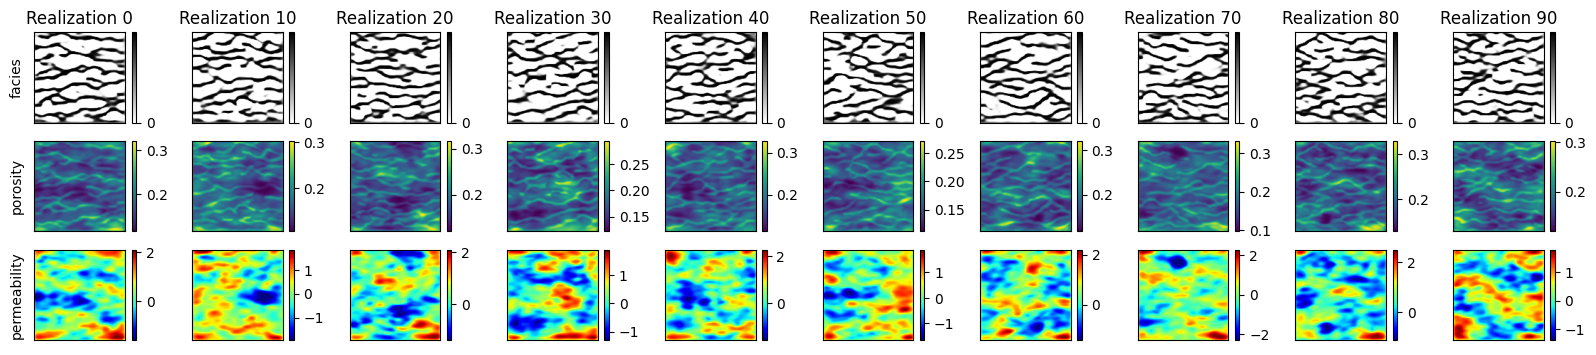

In [18]:
poro_hat, perm_hat, channels_hat = make_inv_backnorm([inv_train, inv_test], [poro, perm, channels])
plot_static(poro_hat, perm_hat, channels_hat, multiplier=10)

***
# END